In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split


In [3]:

# Load metadata
data_path = '../NeoJaundice/chd_jaundice.csv'  # Update with actual path
df = pd.read_csv(data_path)

# Define image directory
image_dir = "../NeoJaundice/images"  # Update with actual path


In [4]:
# Image preprocessing function
def load_and_preprocess_image(patient_id, img_idx, target_size=(224, 224)):
    img_path = os.path.join(image_dir, f"{patient_id}-{img_idx}.jpg")  # Assuming .jpg format
    img = cv2.imread(img_path)
    img = cv2.resize(img, target_size)
    img = img / 255.0  # Normalize
    return img

In [5]:

# Prepare dataset
X_head, X_face, X_chest, Y = [], [], [], []
for _, row in df.iterrows():
    patient_id = str(row['patient_id']).zfill(4)  # Ensure proper ID format
    bilirubin_level = row['blood(mg/dL)']
    
    X_head.append(load_and_preprocess_image(patient_id, 1))
    X_face.append(load_and_preprocess_image(patient_id, 2))
    X_chest.append(load_and_preprocess_image(patient_id, 3))
    Y.append(bilirubin_level)

In [7]:
# Convert to numpy arrays
X_head, X_face, X_chest, Y = map(np.array, [X_head, X_face, X_chest, Y])

# Split dataset
X_head_train, X_head_test, X_face_train, X_face_test, X_chest_train, X_chest_test, Y_train, Y_test = train_test_split(
    X_head, X_face, X_chest, Y, test_size=0.2, random_state=42
)

In [8]:
# Define CNN branch
def build_cnn_branch(input_shape):
    inp = Input(shape=input_shape)
    x = Conv2D(32, (3,3), padding='same')(inp)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2,2))(x)
    
    x = Conv2D(64, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2,2))(x)
    
    x = Flatten()(x)
    return inp, x

In [9]:
# Build multi-input model
input_shape = (224, 224, 3)
inp_head, feat_head = build_cnn_branch(input_shape)
inp_face, feat_face = build_cnn_branch(input_shape)
inp_chest, feat_chest = build_cnn_branch(input_shape)

In [10]:
merged = Concatenate()([feat_head, feat_face, feat_chest])
x = Dense(128, activation='relu')(merged)
x = Dense(64, activation='relu')(x)
out = Dense(1)(x)  # Regression output

In [11]:
model = Model(inputs=[inp_head, inp_face, inp_chest], outputs=out)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

In [13]:
# Train model
history = model.fit(
    [X_head_train, X_face_train, X_chest_train], Y_train, 
    validation_data=([X_head_test, X_face_test, X_chest_test], Y_test),
    epochs=10, batch_size=16
)

Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - loss: 58.9093 - mae: 6.0706 - val_loss: 22.4631 - val_mae: 3.6421
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - loss: 34.3437 - mae: 4.7046 - val_loss: 28.2153 - val_mae: 4.0879
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 244s 2s/step - loss: 18.1342 - mae: 3.3534 - val_loss: 46.7348 - val_mae: 6.4626
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - loss: 12.8252 - mae: 2.8131 - val_loss: 10.8571 - val_mae: 2.7938
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - loss: 39.3670 - mae: 5.1933 - val_loss: 11.9353 - val_mae: 2.7662
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - loss: 11.6011 - mae: 2.7299 - val_loss: 4.7397 - val_mae: 1.7130
Epoch 7/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - loss: 14.5246 - mae: 2.9914 - val_loss: 16.0215 - val_mae: 3.2611
Epoch 8/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - loss: 20.7801 - mae: 3.4781 - val_loss: 60.9562 - val_mae: 6.5436
Epoch 9/10
112/112 ━━━━━━━━━━━━━━

In [14]:
# Evaluate model
loss, mae = model.evaluate([X_head_test, X_face_test, X_chest_test], Y_test)
print(f"Test MAE: {mae}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 553ms/step - loss: 30.6191 - mae: 5.0116
Test MAE: 4.889860153198242


In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess image
def load_image(image_path, target_size=(100, 100)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image /= 255.0  # Normalize
    return image


In [5]:
# Sample image path (replace with your image path)
sample_image_path = "../NeoJaundice/images/0001-1.jpg"
image = load_image(sample_image_path)

# Define a simple CNN model
input_layer = Input(shape=(100, 100, 3))
conv1 = Conv2D(32, (3, 3), activation='relu')(input_layer)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu')(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
flatten = Flatten()(pool2)
dense = Dense(64, activation='relu')(flatten)
output_layer = Dense(1, activation='sigmoid')(dense)

model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 33856)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,166,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,186,305 (8.34 MB)

 Trainable params: 2,186,305 (8.34 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Create a new model to extract outputs of each Conv layer
layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name]
feature_map_model = Model(inputs=model.input, outputs=layer_outputs)

# Generate feature maps
feature_maps = feature_map_model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


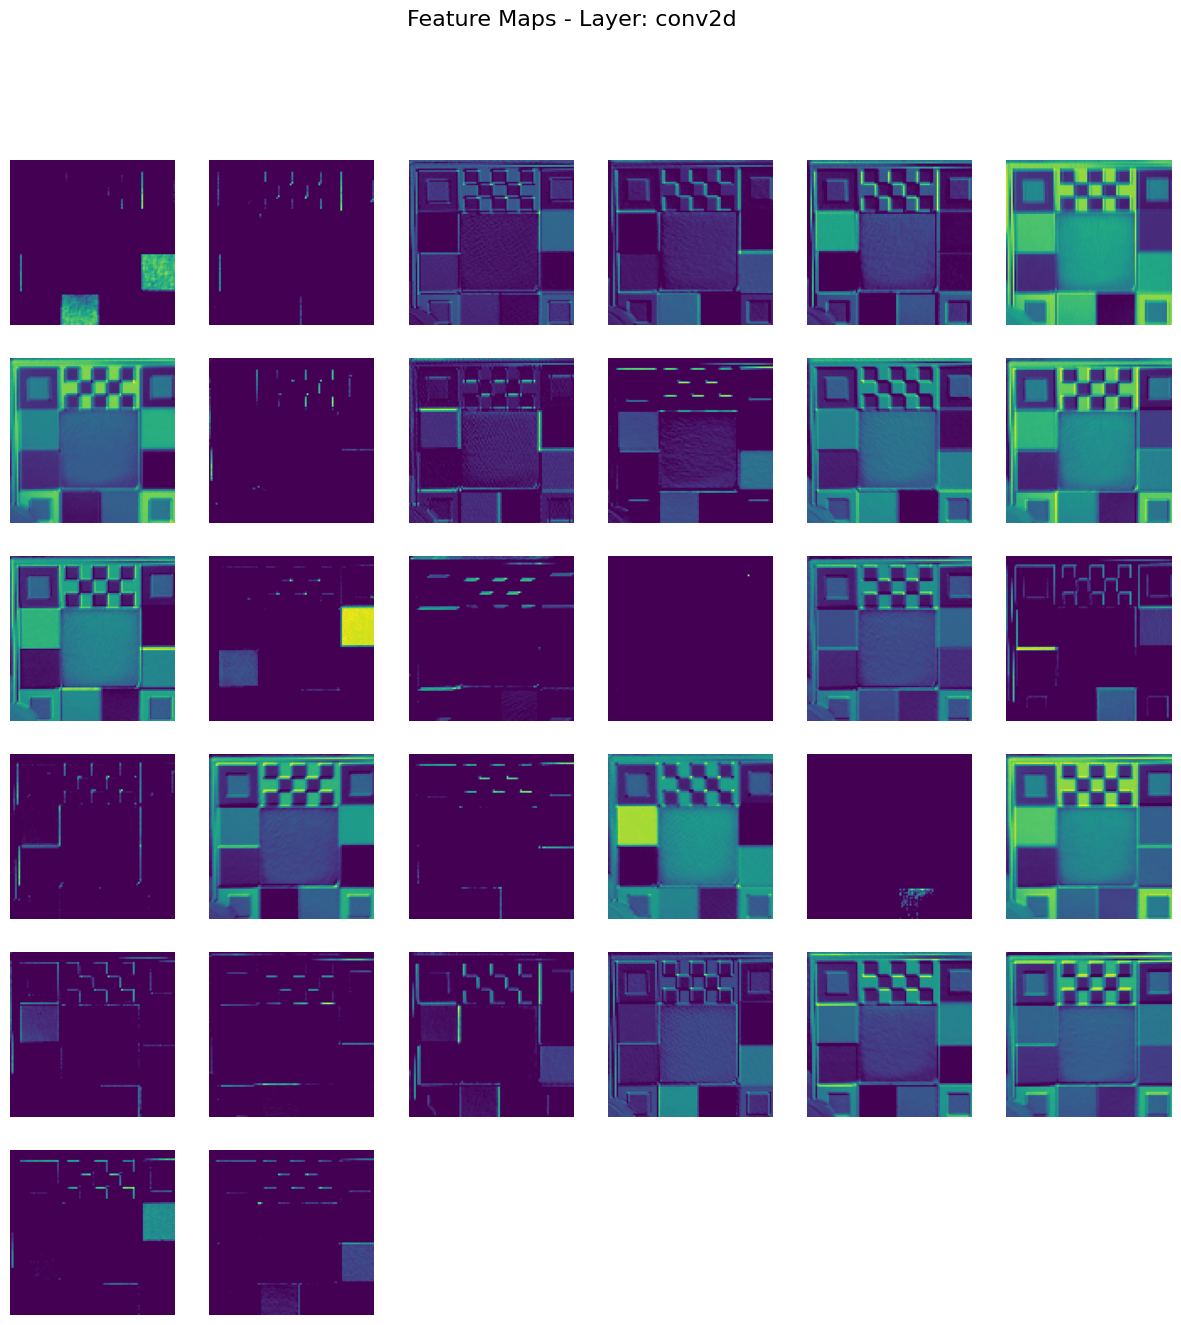

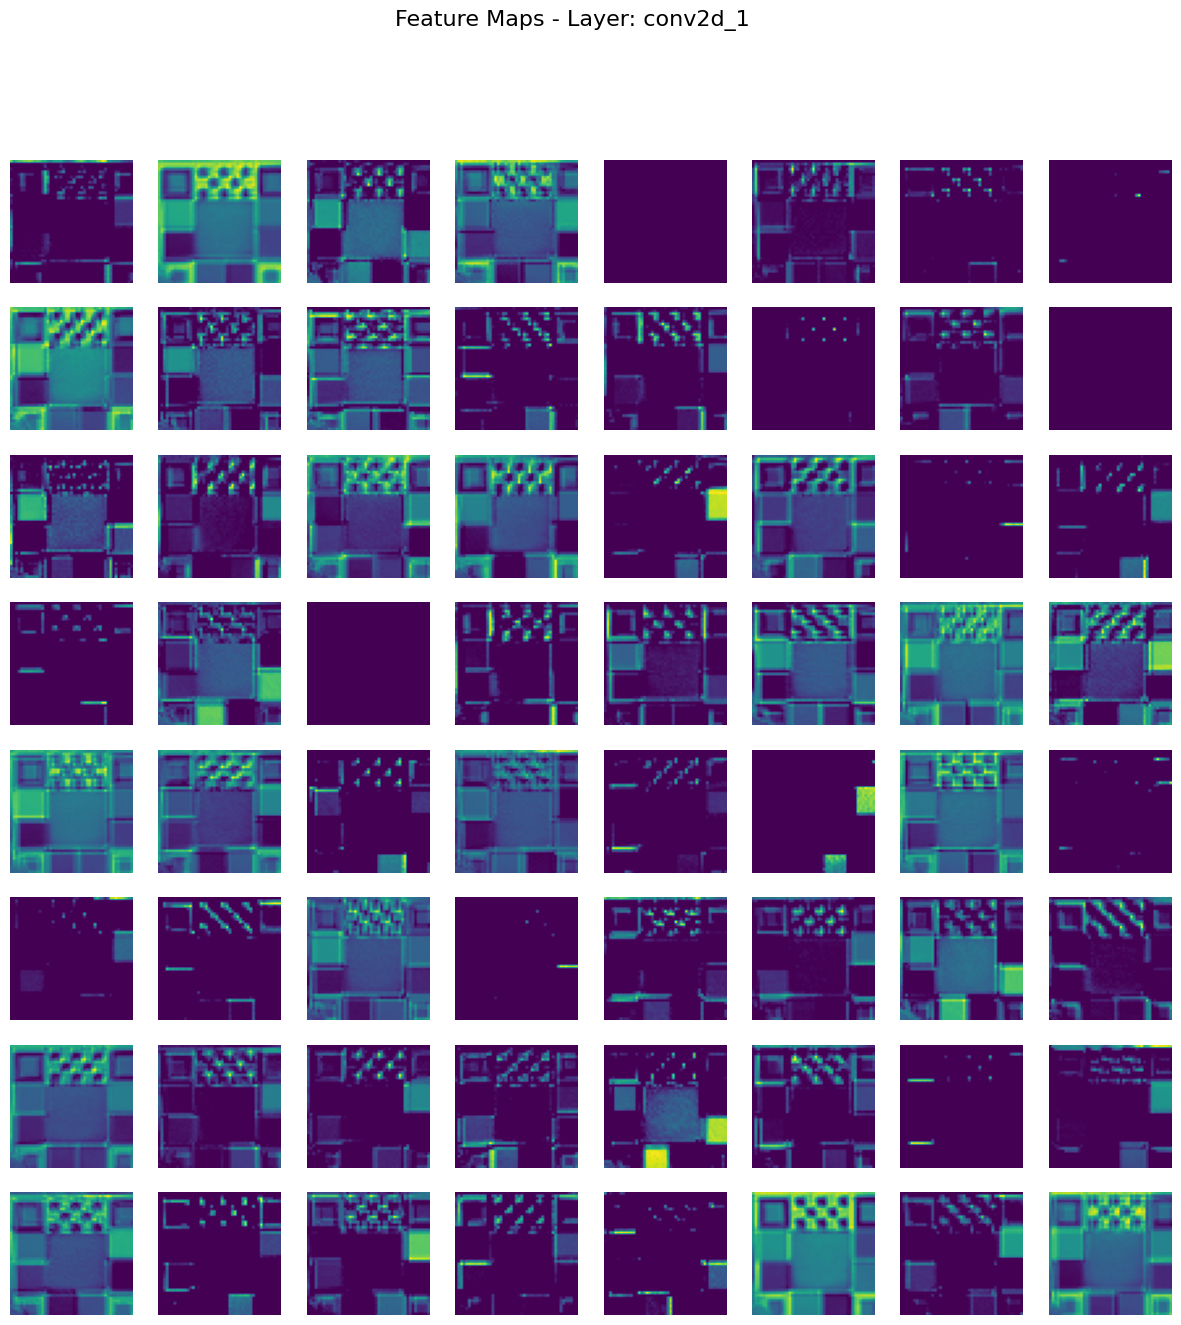

In [8]:
# Visualize feature maps
# Improved function to plot feature maps in a grid
def plot_feature_maps(feature_maps, layer_names):
    for fmap, lname in zip(feature_maps, layer_names):
        fmap = np.squeeze(fmap)
        num_filters = fmap.shape[-1]
        
        # Calculate grid size
        grid_size = int(np.ceil(np.sqrt(num_filters)))
        
        fig, ax = plt.subplots(grid_size, grid_size, figsize=(15, 15))
        fig.suptitle(f"Feature Maps - Layer: {lname}", fontsize=16)
        
        for i in range(grid_size * grid_size):
            row, col = divmod(i, grid_size)
            ax[row][col].axis('off')
            
            # Only plot existing feature maps
            if i < num_filters:
                ax[row][col].imshow(fmap[..., i], cmap='viridis')
        
        plt.show()


# Extract layer names
layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]

# Plot the feature maps
plot_feature_maps(feature_maps, layer_names)

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define image dimensions and batch size
img_width, img_height = 100, 100
batch_size = 32

# Set paths
image_dir = '../NeoJaundice/images'
csv_file = '../NeoJaundice/chd_jaundice.csv'

In [15]:
# Load CSV
df = pd.read_csv(csv_file)
df['label'] = (df['blood(mg/dL)'] >= 12.9).astype(int)  # Label: 1 for jaundiced, 0 for non-jaundiced

# Display label distribution
print("Label Distribution:\n", df['label'].value_counts())

# Split data into train, validation, and test
train_df, test_df = train_test_split(df, test_size=0.15, stratify=df['label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.15, stratify=train_df['label'], random_state=42)

# Load and preprocess images
def load_and_preprocess_images(df, image_dir):
    images = []
    labels = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        img_path = os.path.join(image_dir, row['image_idx'])
        image = cv2.imread(img_path)
        image = cv2.resize(image, (img_width, img_height))
        image = image / 255.0  # Normalize
        images.append(image)
        labels.append(row['label'])
    return np.array(images), np.array(labels)

# Load images and labels for train, validation, and test sets
X_train, y_train = load_and_preprocess_images(train_df, image_dir)
X_val, y_val = load_and_preprocess_images(val_df, image_dir)
X_test, y_test = load_and_preprocess_images(test_df, image_dir)

print(f"Train set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

Label Distribution:
 label
0    1287
1     948
Name: count, dtype: int64


100%|██████████| 336/336 [00:12<00:00, 26.55it/s]

Train set: (1614, 100, 100, 3), Validation set: (285, 100, 100, 3), Test set: (336, 100, 100, 3)


In [16]:
# Build CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()

C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,731,905 (6.61 MB)

 Trainable params: 1,731,905 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=batch_size
)

Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.5690 - loss: 0.6947 - val_accuracy: 0.5754 - val_loss: 0.6670
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.6051 - loss: 0.6494 - val_accuracy: 0.7509 - val_loss: 0.5470
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - accuracy: 0.6862 - loss: 0.5761 - val_accuracy: 0.6982 - val_loss: 0.5435
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.7282 - loss: 0.5397 - val_accuracy: 0.7509 - val_loss: 0.5279
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.7425 - loss: 0.5156 - val_accuracy: 0.7579 - val_loss: 0.4886
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - accuracy: 0.7417 - loss: 0.5202 - val_accuracy: 0.7895 - val_loss: 0.4874
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - accuracy: 0.7679 - loss: 0.4846 - val_accuracy: 0.7509 - val_loss: 0.4731
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.7670 - loss: 0.4768 - val_accuracy

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7976 - loss: 0.4645
Test Accuracy: 77.38%
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step

Classification Report:
               precision    recall  f1-score   support

non_jaundiced       0.85      0.74      0.79       193
    jaundiced       0.70      0.82      0.75       143

     accuracy                           0.77       336
    macro avg       0.77      0.78      0.77       336
 weighted avg       0.78      0.77      0.78       336


Confusion Matrix:
[[143  50]
 [ 26 117]]


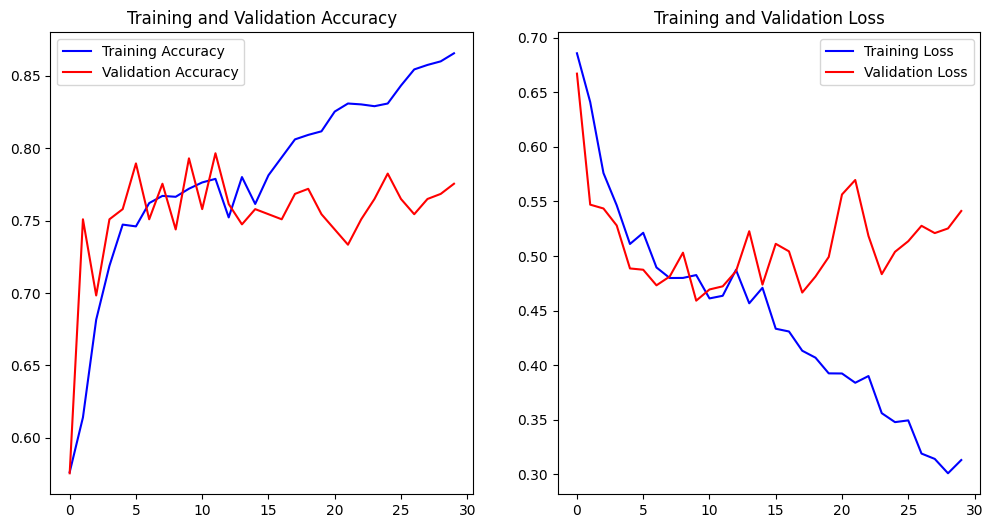

Model saved as neo_jaundice_cnn_model.h5


In [18]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Predictions and classification report
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int).flatten()

from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['non_jaundiced', 'jaundiced']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Plot training and validation accuracy and loss
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_training_history(history)

# Save the trained model
model.save('neo_jaundice_cnn_model.h5')
print("Model saved as neo_jaundice_cnn_model.h5")